<a href="https://colab.research.google.com/github/farfaness/Machine_learning/blob/master/Regularisation_LassoRidge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Méthode de Régularisation : Lasso & Ridge 


Dans le domaine des mathématiques et des statistiques, et plus particulièrement dans le domaine de l'apprentissage automatique, la régularisation fait référence à un processus consistant à **ajouter de l'information à un problème pour éviter le surapprentissage. Cette information prend généralement la forme d'une pénalité envers la complexité du modèle.** D'un point de vue bayésien, l'utilisation de la régularisation revient à imposer une distribution a priori sur les paramètres du modèle. 



## La méthode Lasso 

En statistiques, le lasso est une méthode de contraction des coefficients de la régression développée par Robert Tibshirani dans **un article publié en 1996** intitulé [Regression shrinkage and selection via the lasso](https://pdfs.semanticscholar.org/1b65/af0b2847cf6edb1461eda659f08be27bc76d.pdf).

Nous cherchons à expliquer de manière linéaire une variable $Y$ , par $p$ variables potentiellement explicatives $X_i$. Pour cela nous faisons $n$ observations et nous modèlisons la variable $Y$ de la manière suivante : $$Y=X \beta + \varepsilon$$

La question maintenant est de savoir quelle variable parmis les $p$ variables ont le plus de poids dans notre explicaton ! C'est donc l'objet de la méthode Lasso.    

Pour plus de détail je vous invite à consulter le cour de Pierre Gaillard et Anisse Ismaili, [Le Lasso, ou comment choisir parmi un grand nombre de variables à l'aide de peu d'observations](http://pierre.gaillard.me/doc/Ga09-report.pdf)


In [0]:
import warnings
warnings.simplefilter("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import linear_model #modèle linéaire
from sklearn.metrics import mean_squared_error, r2_score #métriques d'évaluation

In [0]:
# read data
data = pd.read_csv("/content/houseData.csv", sep=",")
data.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [0]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [0]:
data.info(memory_usage = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


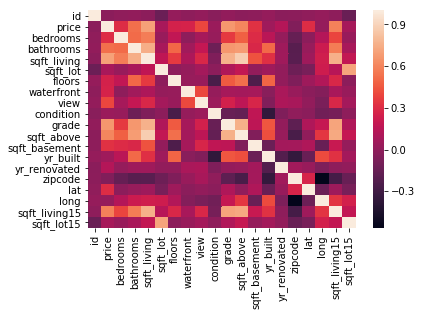

In [0]:
sns.heatmap(data.corr())

Notre target : price (variable numérique). Notre objectif ici est donc de prédire le prix d'un appartement en fonction de différents facteurs (nbr métre carré de l'appartement, nbr de chambres, nbr de salle de bains, emplacement de l'appartement, état de l'appartement, l'année de construction...). Tout les features ici sont numériques sauf le zip code qui même si il s'exprime sous la forme de chiffres représente des catégories, et la date qui est un objet, et l'ID qui le numéro d'identification de l'appartement.
On utilisera ici une regression linéaire multiple avec régularisation lasso car on a beaucoup de variables, et en plus de la multicollinéarité entre ces variables. La pénalisation lasso va nous permettre de sélectionner un sous-ensemble de variables en exerçant une contrainte sur les coefficients de régréssion des VIs de notre modèle.

In [0]:
# Dimension du dataset 
data.shape

(21613, 21)

In [0]:
data['id'].value_counts()

795000620     3
2206700215    2
643300040     2
3333002450    2
1995200200    2
1781500435    2
3904100089    2
3323059027    2
6300000226    2
9809000020    2
723049156     2
1254200015    2
2560801222    2
6669020290    2
8651402750    2
3969300030    2
1237500540    2
4154300296    2
4302201085    2
1450100390    2
9250900104    2
4443800385    2
2892700041    2
5127001320    2
5083000375    2
2621600015    2
7129304540    2
4222310010    2
5101405604    2
2619920170    2
             ..
2516000475    1
9454200030    1
8857640710    1
7519001825    1
3992700130    1
7515000035    1
5608010980    1
475000510     1
4038300010    1
9238480020    1
9492500170    1
8165500110    1
1931300035    1
1525200060    1
880000189     1
7974200510    1
6815100095    1
2617300160    1
2768100545    1
3324069058    1
2607740100    1
880000205     1
1922000070    1
7893808220    1
3333002440    1
3420069065    1
7812801125    1
4364700875    1
3021059276    1
1777500160    1
Name: id, Length: 21436,

In [0]:
pd.set_option('display.max_columns', 21)
print(data[data['id'] == 795000620])

              id             date     price  bedrooms  bathrooms  sqft_living  \
17602  795000620  20140924T000000  115000.0         3        1.0         1080   
17603  795000620  20141215T000000  124000.0         3        1.0         1080   
17604  795000620  20150311T000000  157000.0         3        1.0         1080   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
17602      6250     1.0           0     0          2      5        1080   
17603      6250     1.0           0     0          2      5        1080   
17604      6250     1.0           0     0          2      5        1080   

       sqft_basement  yr_built  yr_renovated  zipcode      lat    long  \
17602              0      1950             0    98168  47.5045 -122.33   
17603              0      1950             0    98168  47.5045 -122.33   
17604              0      1950             0    98168  47.5045 -122.33   

       sqft_living15  sqft_lot15  
17602           1070        6250  
17603  

In [0]:
#enlever les colonnes non pertinentes 
data.drop(columns=['id', 'date', 'waterfront', 'view'])
data.shape

(21613, 21)

In [0]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [0]:
bedrooms = data['bedrooms'].value_counts()
print(bedrooms)

3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
8       13
0       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64


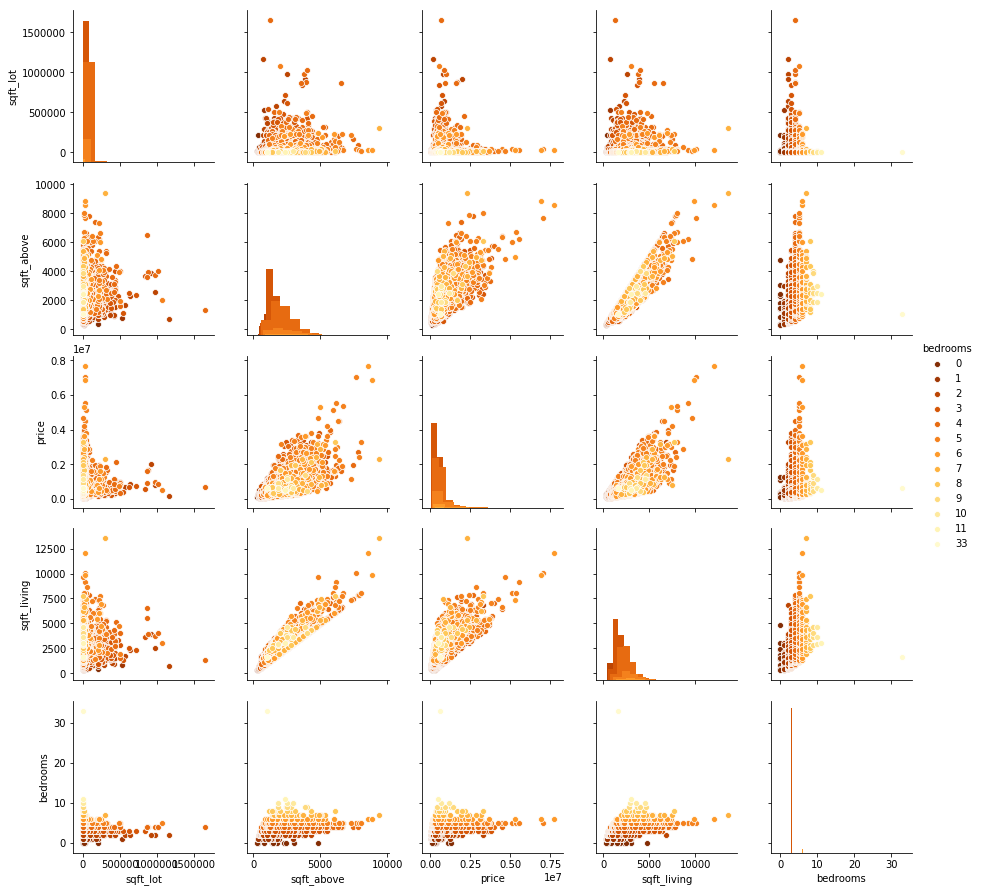

In [0]:
#Pairplot en mettant en argument bedrooms afin de regarder l'impact de cette variable  
data_plot = data.loc[:, ['sqft_lot', 'sqft_above', 'price', 'sqft_living', 'bedrooms']]
sns.pairplot(data_plot, vars=['sqft_lot', 'sqft_above', 'price', 'sqft_living', 'bedrooms'], hue = 'bedrooms', diag_kind='hist', palette = 'YlOrBr_r')

In [0]:
#Extraction des valeurs du prix (le vecteur cible) dans une nouvelle variable et afficher sa taille 
y = data['price']
len(y)

21613

In [0]:
#Suppression de la variable prix de notre set de VD car il s'agit de la target
data = data.drop(columns=['price']) 

In [0]:
#Création de notre set de VD: X 
X = data.loc[:, ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15' ]]

In [0]:
#Liste avec le nom des colonnes
liste_colonnes = X.columns.tolist()
print(liste_colonnes)

['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [0]:
#Creation d'un 'Lasso estimator'
lasso = linear_model.Lasso(alpha=0.2, normalize=True)

In [0]:
#Fiter sur votre ensemble de donnée 
lasso.fit(X, y)

Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [0]:
#Affichage des coefficients 
print(lasso.coef_)

[-4.60371681e+04  4.27861001e+04  2.09910162e+02  1.55917506e-01
  1.10125833e+04  2.91820514e+04  1.01162856e+05 -2.23999188e+01
 -3.02780899e+01 -2.82963779e+03  3.48449523e+01 -4.76908000e+02
  5.55627700e+05 -2.51484241e+05  4.00319113e+01 -3.23987600e-01]


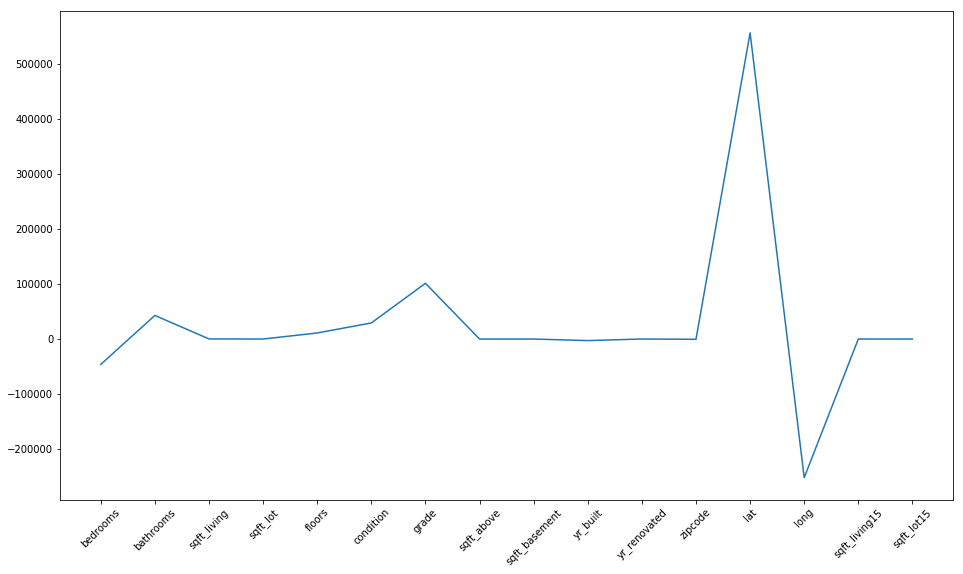

In [0]:
# Plot des coefficients avec les bon noms
plt.figure(figsize=(16,9))
plt.xticks(rotation = 45)
plt.plot(liste_colonnes, lasso.coef_)

In [0]:
# Lasso avec un alpha = 100 et affichage des coefs
lasso_100 = linear_model.Lasso(alpha=100, normalize=True)
lasso_100.fit(X, y)
print(lasso_100.coef_)

[-2.21651222e+03  3.76966686e+03  1.70151388e+02  0.00000000e+00
  0.00000000e+00  1.01307729e+04  1.02366456e+05  0.00000000e+00
  0.00000000e+00 -1.94583213e+03  1.53104933e+01 -0.00000000e+00
  4.70758627e+05 -7.68871412e+04  2.19537362e+01 -0.00000000e+00]


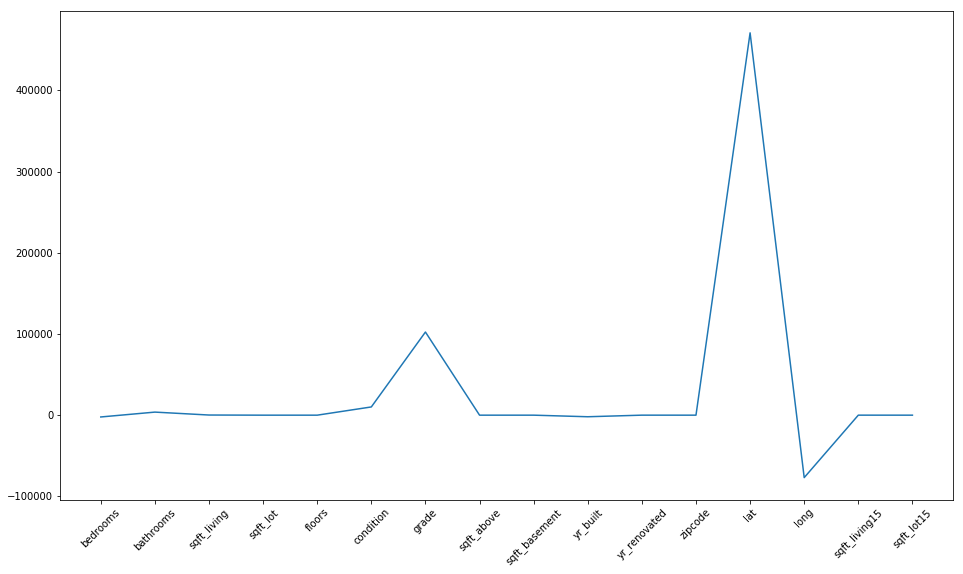

In [0]:
# Affichage de la courbe 
plt.figure(figsize=(16,9))
plt.xticks(rotation = 45)
plt.plot(liste_colonnes, lasso_100.coef_)

In [0]:
# Pareil avec un alpha = 1000 et affichage des coefs
lasso_1000 = linear_model.Lasso(alpha=1000, normalize=True)
lasso_1000.fit(X, y)
print(lasso_1000.coef_)

[    0.             0.            93.61923199     0.
     0.             0.         27594.4045107      0.
     0.            -0.             0.             0.
     0.            -0.             0.             0.        ]


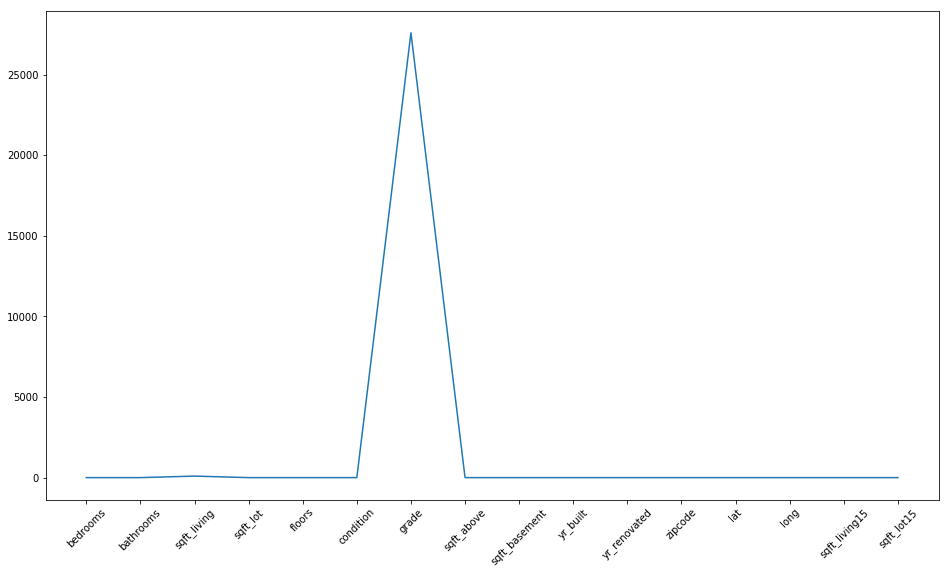

In [0]:
#Affichage de la courbe 
plt.figure(figsize=(16,9))
plt.xticks(rotation = 45)
plt.plot(liste_colonnes, lasso_1000.coef_)

## La cross validation
 La validation croisée (ou cross-validation) est en apprentissage automatique, une méthode d’estimation de fiabilité d’un modèle fondé sur une technique d’échantillonnage.


In [0]:
# Tableau de cross validation et la moyenne 
from sklearn.model_selection import cross_val_score
lasso = linear_model.Lasso(alpha = 0.2, normalize=True) #mettre shuffle = True si le dataset n'est pas mélangé
scores = cross_val_score(lasso, X, y, cv=5)
print(scores)

avg_score = np.mean(scores)
print(avg_score)

[0.64114074 0.65608487 0.66156053 0.6750536  0.65556568]
0.6578810832739276


### Lasso path
Lorsque α est trop élevé, tous les coefficients de la régression sont nuls ; lorsque α est trop faible, proche de 0, nous obtenons les coefficients de la régression linéaire multiple usuelle. Il faut trouver le juste milieu et c’est toute la difficulté de la régression Lasso. L’outil « Lasso path » peut nous y aider. Il produit un graphique qui met en relation les différentes versions de α avec les coefficients estimés. La régression Lasso, contrairement à Ridge, permet de réaliser une sélection de variables en mettant à zéro sélectivement les coefficients. Nous voyons ainsi se dessiner des scénarios de solutions (au sens « différents ensembles de variables sélectionnées ») tout au long du « Lasso path ».


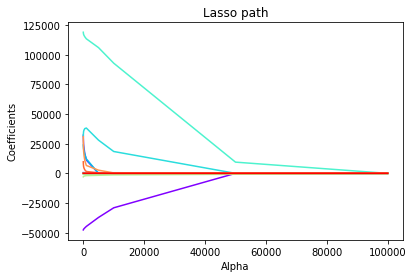

<Figure size 1152x648 with 0 Axes>

In [0]:
from sklearn.linear_model import lasso_path
# Use lasso_path to compute a coefficient path
my_alphas = [0.2, 10, 50, 100, 250, 500, 1000, 5000, 10000, 50000, 100000]
alpha_for_path, coefs_lasso, _ = lasso_path(X, y,alphas=my_alphas, normalize=True)

#jeu de couleurs pour faire joli
import matplotlib.cm as cm
couleurs = cm.rainbow(np.linspace(0,1,16))

#graphique lasso path (une courbe par variable)
for i in range(coefs_lasso.shape[0]): #nbr ligne = nbr variables, et nbr_colonnes = nbr coeff alpha testés
 plt.plot(alpha_for_path,coefs_lasso[i,:], c=couleurs[i])

plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso path')
plt.figure(figsize=(16,9))
plt.show()

In [0]:
#Nombre de coefs. non-nuls pour chaque alpha
nbNonZero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso,axis=0)
print(pd.DataFrame({'alpha':alpha_for_path,'Nb non-zero coefs':nbNonZero}))

       alpha  Nb non-zero coefs
0   100000.0                  8
1    50000.0                  9
2    10000.0                 13
3     5000.0                 14
4     1000.0                 16
5      500.0                 16
6      250.0                 16
7      100.0                 16
8       50.0                 16
9       10.0                 16
10       0.2                 16


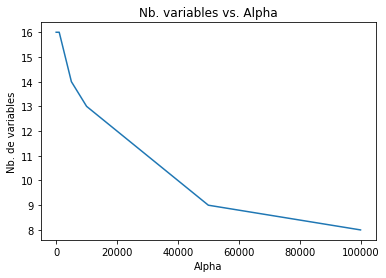

In [0]:
#ou sous forme graphique
plt.plot(alpha_for_path,nbNonZero)
plt.xlabel('Alpha')
plt.ylabel('Nb. de variables')
plt.title('Nb. variables vs. Alpha')
plt.show()

In [0]:
#nom des variables séléctionnée pour un alpha donné
nom_var = liste_colonnes
#coefficients pour alpha=10000 (colonne n°2)
coefs10000 = coefs_lasso[:,2]
#affichage des coefficients pourcet alpha
print(pd.DataFrame({'Variables':nom_var,'Coefficients':coefs10000}))

        Variables  Coefficients
0        bedrooms -29024.201557
1       bathrooms      0.000000
2     sqft_living    531.876809
3        sqft_lot      0.044837
4          floors      0.000000
5       condition  18419.113171
6           grade  92839.775109
7      sqft_above   -341.138771
8   sqft_basement   -300.690207
9        yr_built  -1295.122996
10   yr_renovated     66.663453
11        zipcode     19.487384
12            lat    356.290177
13           long     -0.000000
14  sqft_living15     41.510143
15     sqft_lot15     -0.667964


### Optimisation en validation croisée
Nous disposons de scénarios de solutions pour différentes versions de α. Mais nous ne savons pas laquelle est la plus performante en prédiction. Dans cette section, nous utilisons la validation croisée LassoCV() pour l’identifier.

In [0]:
from sklearn.linear_model import LassoCV

my_alphas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 10, 50, 100]

#cv = 5 pour 5-fold validation croisée
lcv = LassoCV(alphas=my_alphas,normalize=True,fit_intercept=False,random_state=0,cv=5)
reg = lcv.fit(X, y)

#valeurs des alphas qui ont été testés
print(lcv.alphas_) 

#valeurs des MSE en validation croisée
print(lcv.mse_path_)

[1.e+02 5.e+01 1.e+01 2.e-01 1.e-01 5.e-02 4.e-02 3.e-02 2.e-02 1.e-02]
[[6.40124601e+10 5.78259364e+10 4.85787965e+10 5.11515832e+10
  5.59550171e+10]
 [6.30212952e+10 5.67747773e+10 4.76412300e+10 5.01397550e+10
  5.51087729e+10]
 [6.22257900e+10 5.59451767e+10 4.68831696e+10 4.93452877e+10
  5.45703224e+10]
 [6.15859381e+10 5.52722824e+10 4.62710556e+10 4.87069282e+10
  5.41830470e+10]
 [6.10694020e+10 5.47234604e+10 4.57770036e+10 4.81920321e+10
  5.39079199e+10]
 [6.06505364e+10 5.42732393e+10 4.53762675e+10 4.77749121e+10
  5.37145280e+10]
 [6.03089837e+10 5.39015651e+10 4.50492025e+10 4.74350410e+10
  5.35817750e+10]
 [6.00286658e+10 5.35925710e+10 4.47803432e+10 4.71562370e+10
  5.34934902e+10]
 [5.97968843e+10 5.33336917e+10 4.45575149e+10 4.69257405e+10
  5.34373267e+10]
 [5.96036095e+10 5.31149687e+10 4.43711321e+10 4.67334907e+10
  5.34038976e+10]]


In [0]:
#moyenne MSE en validation croisée pour chaque alpha
avg_mse = np.mean(lcv.mse_path_,axis=1)

#alphas vs. MSE en cross-validation
print(pd.DataFrame({'alpha':lcv.alphas_,'MSE':avg_mse})) 

    alpha           MSE
0  100.00  5.550476e+10
1   50.00  5.453717e+10
2   10.00  5.379395e+10
3    0.20  5.320385e+10
4    0.10  5.273396e+10
5    0.05  5.235790e+10
6    0.04  5.205531e+10
7    0.03  5.181026e+10
8    0.02  5.161023e+10
9    0.01  5.144542e+10


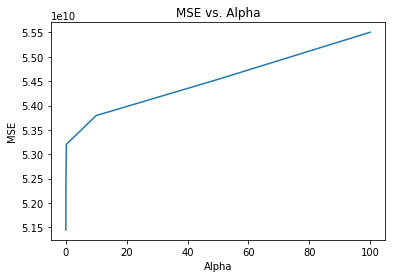

In [0]:
#sous-forme graphique
plt.plot(lcv.alphas_,avg_mse)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('MSE vs. Alpha')
plt.show()


Best alpha = 10000
C'est à dire le modèle avec 10 variables : bedrooms, bathrooms, sqft_living, condition, grade, yr_built, yr_renovated, lat, long, sqft_living15.  



# Régressions Régularisées

La régularisation consiste à introduire une notion de pénalité dans notre manière de mesurer l'érreur (la somme des erreurs au carré pour nous) cela nous permet donc d'inférer sur nos paramètres. Il faut ajuster ce terme de régularisation dans le but d’obtenir un modèle de meilleure qualité. 

La régularisation de Tikhonov, plus connue sous le nom de **"ridge regression"** est une méthode qui consiste à ajouter une contrainte sur les coefficients lors de la modélisation pour maîtriser l’amplitude de leurs valeurs (« pour éviter qu’elles partent dans tous les sens »)

On va donc essayé d'appliquer Ridge sur nos données.

In [0]:
# Définition d'un range de 50 valeur de 10-4 à 1 avec la fonction logspace  

loga = np.logspace(-4, 0, num=50) 
#y = logspace(a,b) generates a row vector y of 50 logarithmically spaced points between decades 10^a and 10^b. 
#The logspace function is especially useful for creating frequency vectors.
loga

array([1.00000000e-04, 1.20679264e-04, 1.45634848e-04, 1.75751062e-04,
       2.12095089e-04, 2.55954792e-04, 3.08884360e-04, 3.72759372e-04,
       4.49843267e-04, 5.42867544e-04, 6.55128557e-04, 7.90604321e-04,
       9.54095476e-04, 1.15139540e-03, 1.38949549e-03, 1.67683294e-03,
       2.02358965e-03, 2.44205309e-03, 2.94705170e-03, 3.55648031e-03,
       4.29193426e-03, 5.17947468e-03, 6.25055193e-03, 7.54312006e-03,
       9.10298178e-03, 1.09854114e-02, 1.32571137e-02, 1.59985872e-02,
       1.93069773e-02, 2.32995181e-02, 2.81176870e-02, 3.39322177e-02,
       4.09491506e-02, 4.94171336e-02, 5.96362332e-02, 7.19685673e-02,
       8.68511374e-02, 1.04811313e-01, 1.26485522e-01, 1.52641797e-01,
       1.84206997e-01, 2.22299648e-01, 2.68269580e-01, 3.23745754e-01,
       3.90693994e-01, 4.71486636e-01, 5.68986603e-01, 6.86648845e-01,
       8.28642773e-01, 1.00000000e+00])

In [0]:
# Création de 2 tableaux pour stocker les résultats : 
# un tableau pour le scrore moyen de la cross-validation (10 epoch)
# un tableau pour la variance moyenne 

#Tableau 1 : mean score of cross-validation
from sklearn.model_selection import cross_val_score

lasso = linear_model.Lasso(alpha = 10000, normalize = True)
scores = cross_val_score(lasso, X, y, cv=10)
avg_score = np.mean(scores)

mean_score_cross_val = np.asarray(avg_score)
print(mean_score_cross_val)

#Tableau 2 : variance moyenne
mean_var = np.var(scores)
print(mean_var)


-0.003154670238029489
4.919179704421637e-05


In [0]:
# Instanciation d'un 'Ridge estimator' normalisé 
my_alphas = loga

ridge = linear_model.Ridge(alpha=my_alphas[0], normalize=True)
ridge.fit(X, y)

scores = cross_val_score(ridge, X, y, cv=10)
avg_score = np.mean(scores)

mean_score_cross_val = []
mean_score_cross_val = np.asarray(avg_score)
print(mean_score_cross_val)

#Tableau 2 : variance moyenne
mean_var = np.var(scores)
print(mean_var)

0.6578402936701846
0.00027486147600913277


In [0]:
# Creation d'une loop sur les alpha 
# --> but : voir l'effet du paramètre alpha sur l'accuracy   

# Pour chaque alpha on va faire 10 cross-validation 
# Et ajouter les résultats à nos tableaux  
my_alphas = loga

for alpha_value in my_alphas[1::] :
  ridge = linear_model.Ridge(alpha = alpha_value, normalize=True)
  scores = cross_val_score(ridge, X, y, cv=10)
  
  mean_score_cross_val = np.append(mean_score_cross_val, np.mean(scores))
  mean_var = np.append(mean_var, np.var(scores))
  
print(mean_score_cross_val)
print(mean_var)

[0.65784029 0.65784063 0.65784103 0.65784152 0.65784211 0.65784281
 0.65784366 0.65784468 0.6578459  0.65784737 0.65784913 0.65785124
 0.65785375 0.65785675 0.65786031 0.65786452 0.65786948 0.6578753
 0.65788207 0.65788988 0.65789879 0.65790879 0.65791979 0.65793151
 0.65794346 0.65795475 0.65796393 0.65796875 0.65796581 0.65795008
 0.65791433 0.6578483  0.65773779 0.65756343 0.65729935 0.6569116
 0.65635659 0.65557936 0.6545121  0.65307275 0.65116398 0.64867258
 0.64546929 0.6414093  0.6363334  0.63007008 0.62243867 0.61325375
 0.60233104 0.589495  ]
[0.00027486 0.00027487 0.00027488 0.00027489 0.0002749  0.00027492
 0.00027494 0.00027497 0.000275   0.00027503 0.00027508 0.00027513
 0.00027519 0.00027527 0.00027536 0.00027547 0.00027561 0.00027577
 0.00027597 0.0002762  0.00027649 0.00027684 0.00027726 0.00027777
 0.00027839 0.00027913 0.00028004 0.00028113 0.00028246 0.00028407
 0.000286   0.00028834 0.00029116 0.00029453 0.00029854 0.00030329
 0.00030886 0.00031533 0.00032273 0.0003

In [0]:
print(len(my_alphas))
print(my_alphas)
print(len(mean_score_cross_val))
  

50
[1.00000000e-04 1.20679264e-04 1.45634848e-04 1.75751062e-04
 2.12095089e-04 2.55954792e-04 3.08884360e-04 3.72759372e-04
 4.49843267e-04 5.42867544e-04 6.55128557e-04 7.90604321e-04
 9.54095476e-04 1.15139540e-03 1.38949549e-03 1.67683294e-03
 2.02358965e-03 2.44205309e-03 2.94705170e-03 3.55648031e-03
 4.29193426e-03 5.17947468e-03 6.25055193e-03 7.54312006e-03
 9.10298178e-03 1.09854114e-02 1.32571137e-02 1.59985872e-02
 1.93069773e-02 2.32995181e-02 2.81176870e-02 3.39322177e-02
 4.09491506e-02 4.94171336e-02 5.96362332e-02 7.19685673e-02
 8.68511374e-02 1.04811313e-01 1.26485522e-01 1.52641797e-01
 1.84206997e-01 2.22299648e-01 2.68269580e-01 3.23745754e-01
 3.90693994e-01 4.71486636e-01 5.68986603e-01 6.86648845e-01
 8.28642773e-01 1.00000000e+00]
50


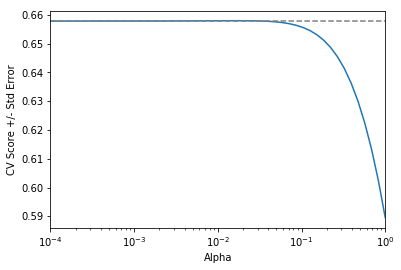

[8.69188305e-05 8.69213564e-05 8.69244048e-05 8.69280839e-05
 8.69325244e-05 8.69378840e-05 8.69443530e-05 8.69521614e-05
 8.69615869e-05 8.69729649e-05 8.69867008e-05 8.70032845e-05
 8.70233079e-05 8.70474871e-05 8.70766881e-05 8.71119589e-05
 8.71545680e-05 8.72060522e-05 8.72682735e-05 8.73434900e-05
 8.74344405e-05 8.75444496e-05 8.76775529e-05 8.78386502e-05
 8.80336877e-05 8.82698742e-05 8.85559322e-05 8.89023822e-05
 8.93218501e-05 8.98293788e-05 9.04427071e-05 9.11824546e-05
 9.20721277e-05 9.31378260e-05 9.44075114e-05 9.59096952e-05
 9.76714384e-05 9.97156377e-05 1.02057707e-04 1.04701911e-04
 1.07637715e-04 1.10836547e-04 1.14249241e-04 1.17804211e-04
 1.21406247e-04 1.24935750e-04 1.28248495e-04 1.31176457e-04
 1.33530723e-04 1.35107761e-04]


In [0]:
# Plot cv scores
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(my_alphas, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(my_alphas, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([my_alphas[0], my_alphas[-1]])
    ax.set_xscale('log')
    plt.show()
    print(std_error)
    
display_plot(cv_scores = mean_score_cross_val, cv_scores_std = mean_var)